__Authors__: Federica Papa, Francesco Daquino, Francesco Maggio, Ondrej Krasnansky, Sandro Cantasano Martino. 

---
# HATE SPEECH DETECTION PROJECT

In [69]:
# Libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import nltk
import plotly.express as px
import re
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline 
from nltk.corpus import stopwords
import warnings 
warnings.filterwarnings("ignore")

In [70]:
import unidecode
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.stem import PorterStemmer
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
import matplotlib.animation as animation
import operator
import plotly.express as px
from collections import Counter

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HUAWEI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HUAWEI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Loading dataset
## Textual data

The focus of this task is the detection of hate speech in strong polarised debates, in particular concerning political and religious topics.

We then created two different datasets called PolicyCorpusXL and ReligiousHate.

PolicyCorpusXL:
7,000 tweets about political debates (5,600 training, 1,400 test)

ReligiousHate:
3,000 tweets about the three main monotheistic religions, namely Christianity, Islam and Judaism (only test)

In [71]:
train = pd.read_csv("development/training_textual.csv")
test = pd.read_csv("test/test_textual.csv")
gold = pd.read_csv("gold/test_textual_gold.csv")

In [72]:
print(train.shape)
print(test.shape)
print(gold.shape)

(5600, 4)
(4400, 3)
(4400, 4)


#### verifica che test e gold sono uguali

In [73]:
prova = gold.drop("label", axis=1)

# Ordina entrambi i DataFrame in base alle stesse colonne
test1 = test.sort_values(by=['anonymized_tweet_id']).reset_index(drop=True)
prova1 = prova.sort_values(by=['anonymized_tweet_id']).reset_index(drop=True)

In [74]:
# Verifica se i DataFrame sono uguali
if test1.equals(prova1):
    print("I DataFrame sono uguali")
else:
    print("I DataFrame non sono uguali")

I DataFrame sono uguali


#### count valori

In [75]:
print(train['dataset'].value_counts(), "\n")
print(test['dataset'].value_counts(), "\n")
print(gold['dataset'].value_counts(), "\n")

dataset
training_politics    5600
Name: count, dtype: int64 

dataset
test_religious    3000
test_politics     1400
Name: count, dtype: int64 

dataset
test_religious    3000
test_politics     1400
Name: count, dtype: int64 



## contextual data

contenuto di **training_contextual.csv**
- anonymized_tweet_id: L'ID del tweet originale è stato sostituito da un numero intero pseudo casuale che identifica un tweet specifico.
- created_at: la data di pubblicazione del tweet *
- retweet_count: il numero di volte in cui il tweet è stato ritwittato *
- favorite_count: Indica approssimativamente quante volte questo tweet è stato apprezzato dagli utenti di Twitter

- fonte *: la fonte utilizzata per la pubblicazione del tweet (es. Android, iOS, web)

- is_reply *: 1 se il tweet è una risposta. 0 altrove

- is_retweet *: 1 se il tweet è un retweet. 0 altrove

- is_quote *: 1 se il tweet è una citazione. 0 altrove

- anonymized_user_id: L'ID autore originale è stato sostituito da un numero intero pseudo casuale (se disponibile)

- user_created_at *: la data in cui l'autore ha creato il suo account

- statuses_count *: il numero di tweet pubblicati dall'autore

- followers_count *: il numero di utenti di Twitter che seguono l'autore

- friends_count *: il numero di utenti di Twitter che l'autore segue

- anonymized_description: l'autodescrizione dell'autore del tweet. Abbiamo applicato lo stesso processo di anonimizzazione applicato al campo anonymized_text del file train_textual.csv

* Il valore potrebbe non essere disponibile o impostato su 0 a causa del fatto che non siamo stati in grado di recuperare i metadati del tweet nel 2022 (molti mesi dopo la data di pubblicazione). Il tweet a freddo può essere rimosso da Twitter o cancellato o reso non disponibile dall'autore)

In [76]:
con_train = pd.read_csv("development/training_contextual.csv")
con_test = pd.read_csv("test/test_contextual.csv")


In [77]:
print(con_train.shape)
print(con_test.shape)

(5600, 15)
(4400, 15)


In [78]:
con_train.columns

Index(['anonymized_tweet_id', 'created_at', 'retweet_count', 'favorite_count',
       'source', 'is_reply', 'is_retweet', 'is_quote', 'anonymized_user_id',
       'user_created_at', 'statuses_count', 'followers_count', 'friends_count',
       'anonymized_description', 'dataset'],
      dtype='object')

In [10]:
# Verifica se ci sono valori mancanti in contextual train
missing_values = con_train.isnull().sum()
print(missing_values)

anonymized_tweet_id         0
created_at                 78
retweet_count              78
favorite_count             78
source                     78
is_reply                   78
is_retweet                 78
is_quote                   78
anonymized_user_id         78
user_created_at            78
statuses_count             78
followers_count            78
friends_count              78
anonymized_description    717
dataset                     0
dtype: int64


In [11]:
# Verifica se ci sono valori mancanti in contextual test
missing_values = con_test.isnull().sum()
print(missing_values)

anonymized_tweet_id         0
created_at                  0
retweet_count               0
favorite_count              0
source                      0
is_reply                    0
is_retweet                  0
is_quote                    0
anonymized_user_id          0
user_created_at             0
statuses_count              0
followers_count             0
friends_count               0
anonymized_description    660
dataset                     0
dtype: int64


#### merge dei dati di textual e contextual - train e gold

In [15]:
# Merging two Train Data Sets TEXTUAL
df_textual = pd.concat([train, gold], ignore_index = True)
df_textual.shape

(10000, 4)

In [16]:
df_textual.head()

,anonymized_tweet_id,anonymized_text,label,dataset
0,217874450618134,@unknown Con tutte le denunce che si sta becca...,1,training_politics
1,360042217507605,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,training_politics
2,817917484817935,Il #m5s ha votato contro le #unionicivili addu...,1,training_politics
3,172580609652325,La #Lega e il #m5s stanno dando a bere all'opi...,0,training_politics
4,145836038456701,Che cosa cambia questa #legge? Caro @667517147...,0,training_politics


In [17]:
# Merging two Train Data Sets CONTEXTUAL
df_contextual = pd.concat([con_train, con_test], ignore_index = True)
df_contextual.shape

(10000, 15)

In [18]:
df_contextual.head()

,anonymized_tweet_id,created_at,retweet_count,favorite_count,source,is_reply,is_retweet,is_quote,anonymized_user_id,user_created_at,statuses_count,followers_count,friends_count,anonymized_description,dataset
0,217874450618134,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,0.0,8.868893e+14,2018-04-01,554.0,748.0,753.0,Avete presente quegli stereotipi sui siciliani...,training_politics
1,360042217507605,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,0.0,2.570741e+14,2011-10-26,35043.0,10838.0,4535.0,Prof di latino e Deputata PD.Ama lo sport la R...,training_politics
2,817917484817935,2018-11-10,195.0,638.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,0.0,6.908473e+14,2009-09-24,139750.0,7971.0,1866.0,"Medico, appassionato di Cinema d'Autore, Music...",training_politics
3,172580609652325,2018-11-22,112.0,377.0,"<a href=""http://twitter.com/download/android"" ...",0.0,0.0,0.0,9.027930e+14,2012-11-27,3356.0,8493.0,5303.0,NaN,training_politics
4,145836038456701,2018-12-02,45.0,143.0,"<a href=""http://twitter.com/#!/download/ipad"" ...",0.0,0.0,0.0,5.308388e+14,2014-01-14,11234.0,10815.0,1810.0,Veneto! Assessore Regionale Sviluppo Economico...,training_politics


In [19]:
# Unire i due dataset sulla base della colonna "ID"
df_final = pd.merge(df_textual, df_contextual, on='anonymized_tweet_id', how='inner')

In [20]:
df_final.shape

(10000, 18)

#### dataset finale

In [21]:
df_final.head()

,anonymized_tweet_id,anonymized_text,label,dataset_x,created_at,retweet_count,favorite_count,source,is_reply,is_retweet,is_quote,anonymized_user_id,user_created_at,statuses_count,followers_count,friends_count,anonymized_description,dataset_y
0,217874450618134,@unknown Con tutte le denunce che si sta becca...,1,training_politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,0.0,8.868893e+14,2018-04-01,554.0,748.0,753.0,Avete presente quegli stereotipi sui siciliani...,training_politics
1,360042217507605,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,training_politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,0.0,2.570741e+14,2011-10-26,35043.0,10838.0,4535.0,Prof di latino e Deputata PD.Ama lo sport la R...,training_politics
2,817917484817935,Il #m5s ha votato contro le #unionicivili addu...,1,training_politics,2018-11-10,195.0,638.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,0.0,6.908473e+14,2009-09-24,139750.0,7971.0,1866.0,"Medico, appassionato di Cinema d'Autore, Music...",training_politics
3,172580609652325,La #Lega e il #m5s stanno dando a bere all'opi...,0,training_politics,2018-11-22,112.0,377.0,"<a href=""http://twitter.com/download/android"" ...",0.0,0.0,0.0,9.027930e+14,2012-11-27,3356.0,8493.0,5303.0,NaN,training_politics
4,145836038456701,Che cosa cambia questa #legge? Caro @667517147...,0,training_politics,2018-12-02,45.0,143.0,"<a href=""http://twitter.com/#!/download/ipad"" ...",0.0,0.0,0.0,5.308388e+14,2014-01-14,11234.0,10815.0,1810.0,Veneto! Assessore Regionale Sviluppo Economico...,training_politics


In [23]:
# Verificare se le colonne dataset 
sono_uguali = df_final['dataset_x'].equals(df_final['dataset_y'])

# Stampa il risultato
if sono_uguali:
    print("Le colonne sono uguali.")
else:
    print("Le colonne non sono uguali.")

Le colonne sono uguali.


In [24]:
#drop e renaming

df_final = df_final.drop('dataset_y', axis=1)

# Before renaming the columns
print("\nBefore modifying column names:\n", df_final.columns)

df_final.rename(columns = {'anonymized_tweet_id':'tweet_id','anonymized_text':'tweet', 'dataset_x':'dataset', 'label':'is_hate_speech'}, inplace = True)
  
# # After renaming the columns
# print("\nAfter modifying first column:\n", df_final.columns)


Before modifying column names:
 Index(['anonymized_tweet_id', 'anonymized_text', 'label', 'dataset_x',
       'created_at', 'retweet_count', 'favorite_count', 'source', 'is_reply',
       'is_retweet', 'is_quote', 'anonymized_user_id', 'user_created_at',
       'statuses_count', 'followers_count', 'friends_count',
       'anonymized_description'],
      dtype='object')


In [25]:
df_final.head(2)

,tweet_id,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_retweet,is_quote,anonymized_user_id,user_created_at,statuses_count,followers_count,friends_count,anonymized_description
0,217874450618134,@unknown Con tutte le denunce che si sta becca...,1,training_politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,0.0,8.868893e+14,2018-04-01,554.0,748.0,753.0,Avete presente quegli stereotipi sui siciliani...
1,360042217507605,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,training_politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,0.0,2.570741e+14,2011-10-26,35043.0,10838.0,4535.0,Prof di latino e Deputata PD.Ama lo sport la R...


#### gestione missing values

In [26]:
# Sostituisci i valori mancanti con la stringa 'nessuna_descrizione'
df_final['anonymized_description'] =df_final['anonymized_description'].fillna('no_description')

In [27]:
# missing anonymized_description
print(df_final.isnull().sum())

tweet_id                   0
tweet                      0
is_hate_speech             0
dataset                    0
created_at                78
retweet_count             78
favorite_count            78
source                    78
is_reply                  78
is_retweet                78
is_quote                  78
anonymized_user_id        78
user_created_at           78
statuses_count            78
followers_count           78
friends_count             78
anonymized_description     0
dtype: int64


In [28]:
df_final = df_final.dropna()
df_final.shape

(9922, 17)

#### sistemo valori in 'dataset' e drop 'is_retweet'

In [29]:
df_final['dataset'].value_counts()

dataset
training_politics    5522
test_religious       3000
test_politics        1400
Name: count, dtype: int64

In [30]:
df_final['dataset'] = df_final['dataset'].replace({'test_religious': 'religious', 'test_politics': 'politics', 'training_politics':'politics'})

In [31]:
df_final['dataset'].value_counts()

dataset
politics     6922
religious    3000
Name: count, dtype: int64

In [32]:
l = ['is_reply', 'is_retweet', 'is_quote']
for e in l:
    print(df_final[e].value_counts())

is_reply
0.0    6586
1.0    3336
Name: count, dtype: int64
is_retweet
0.0    9922
Name: count, dtype: int64
is_quote
0.0    9251
1.0     671
Name: count, dtype: int64


In [33]:
#drop is_retweet
df_final = df_final.drop('is_retweet', axis=1)

In [34]:
# Check if there are any duplicates
duplicate = df_final[df_final.duplicated()]
print("Duplicate Rows :", duplicate.shape[0])

Duplicate Rows : 0


In [35]:
df = df_final.copy()

In [36]:
df.shape

(9922, 16)

#### verifica bilanciamento target

In [37]:
df['is_hate_speech'].value_counts()

is_hate_speech
0    6651
1    3271
Name: count, dtype: int64

In [38]:
df['is_hate_speech'].value_counts(normalize=True)

is_hate_speech
0    0.670329
1    0.329671
Name: proportion, dtype: float64

In [39]:
#check se le classi sono bilanciate
classe_0 =6669
classe_1 =3331
tot = classe_0 + classe_1
print(round(classe_1/tot,2),round(classe_0/tot,2) )

0.33 0.67


<Axes: ylabel='count'>

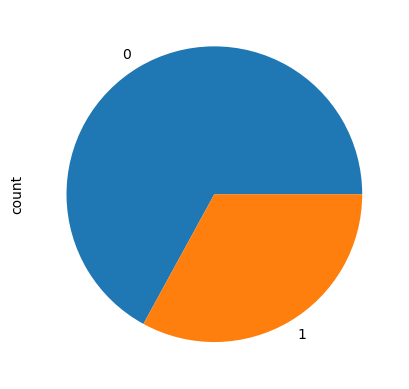

In [40]:
df['is_hate_speech'].value_counts().plot(kind='pie')

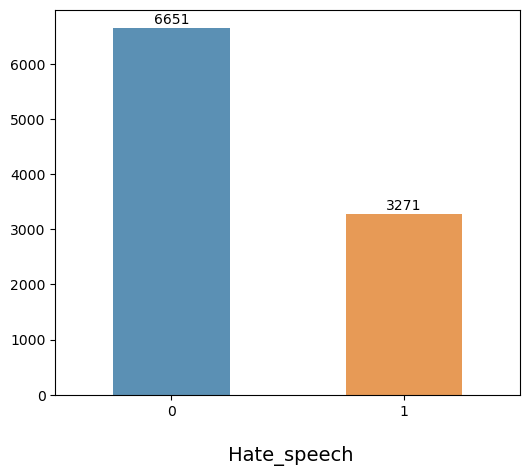

In [41]:
gender = df['is_hate_speech'].value_counts()
plt.figure(figsize=(6, 5))
ax = gender.plot(kind='bar', rot=0, color=["#5B90B4", "#E79A56"])

#ax.set_xlabel('\n Hate_speech')
#ax.set_ylabel('Number of Occurences\n')
# Imposta l'etichetta dell'asse x con la dimensione del carattere desiderata
ax.set_xlabel('\n Hate_speech', fontsize=14)


for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
    
 # Aggiungi il titolo al plot
#ax.set_title('Target Variable Distribution')
plt.show()

The dataset is higly unbalanced. This should be taken into consideration when performing any supervised classification algorithm.

#### verifica range temporale  dei tweet

In [42]:
df.head(2)

,tweet_id,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_quote,anonymized_user_id,user_created_at,statuses_count,followers_count,friends_count,anonymized_description
0,217874450618134,@unknown Con tutte le denunce che si sta becca...,1,politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,8.868893e+14,2018-04-01,554.0,748.0,753.0,Avete presente quegli stereotipi sui siciliani...
1,360042217507605,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,2.570741e+14,2011-10-26,35043.0,10838.0,4535.0,Prof di latino e Deputata PD.Ama lo sport la R...


In [43]:
a = df['created_at'][0]
a

'2018-08-11'

In [44]:
#df.sort_values(by='created_at', ascending=True)

In [46]:
# mi assicuro che la colonna 'date' sia riconosciuta come tipo datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df['user_created_at'] = pd.to_datetime(df['user_created_at'])
type(df['created_at'][0])

pandas._libs.tslibs.timestamps.Timestamp

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


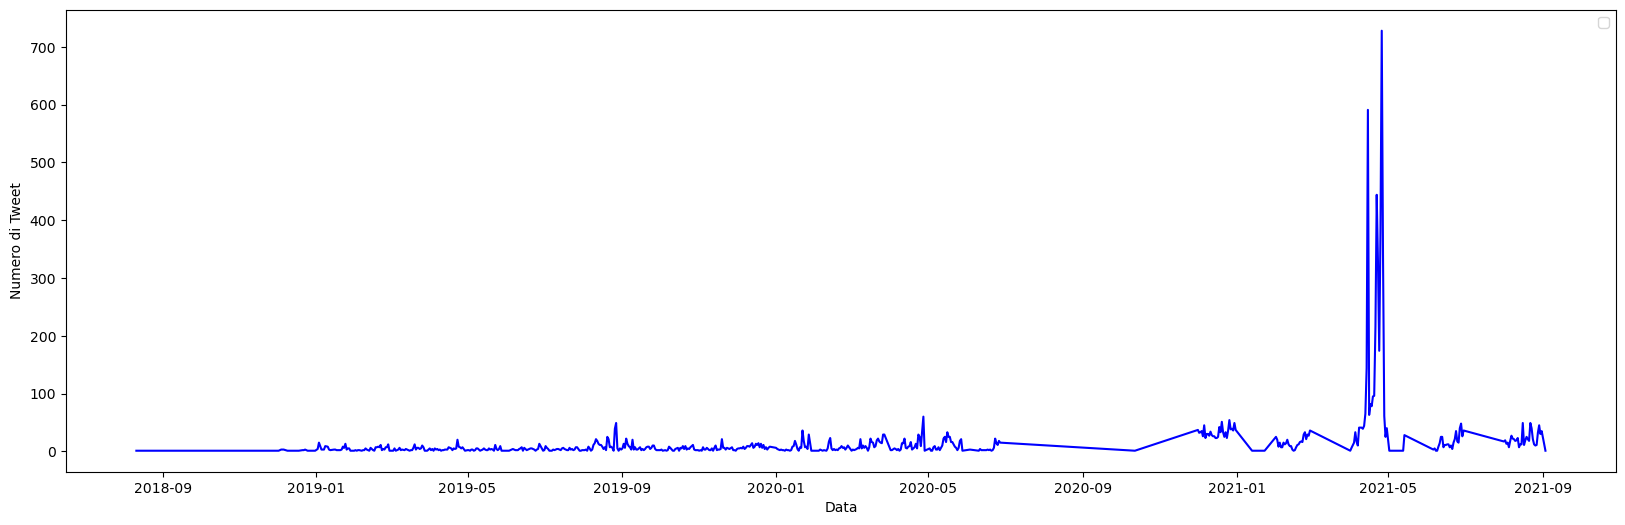

In [47]:
df_date_count = df.groupby('created_at').size()
plt.figure(figsize=(20, 6))
plt.plot(df_date_count.index, df_date_count.values, linestyle='-',  color='blue') #label='Hate Speech'

# Aggiungi legenda
plt.legend()

#plt.title('Tweet nel Tempo')
plt.xlabel('Data')
plt.ylabel('Numero di Tweet')
#plt.grid(True)
plt.show()

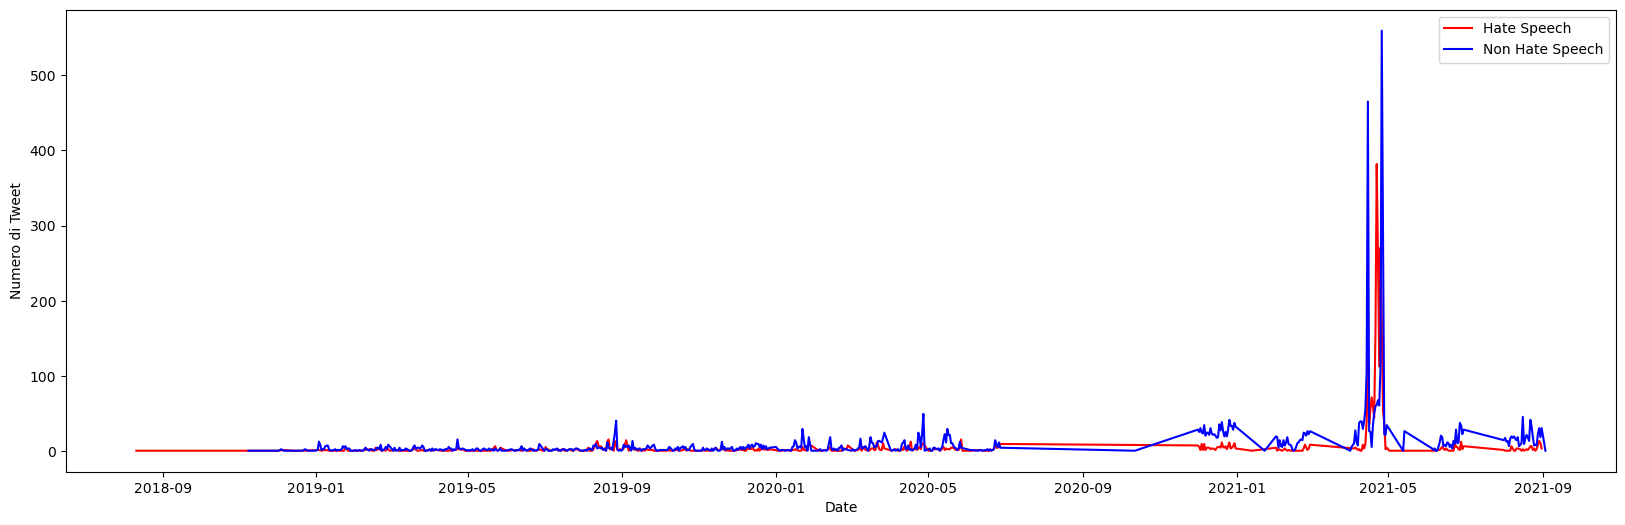

In [48]:
# Filtra i tweet d'odio
hate_speech_tweets = df[df['is_hate_speech'] == 1]
non_hate_speech_tweets = df[df['is_hate_speech'] == 0]

# Raggruppa per data e conta il numero di tweet d'odio per ogni data
hate_speech_count = hate_speech_tweets.groupby('created_at').size()
no_hate_speech_count = non_hate_speech_tweets.groupby('created_at').size()

# Plot
plt.figure(figsize=(20, 6))
plt.plot(hate_speech_count.index, hate_speech_count.values, linestyle='-',  color='red', label='Hate Speech')
plt.plot(no_hate_speech_count.index, no_hate_speech_count.values, linestyle='-', color='blue', label='Non Hate Speech')


# Aggiungi legenda
plt.legend()

#plt.title('Tweet nel Tempo')
plt.xlabel('Date')
plt.ylabel('Numero di Tweet')
#plt.grid(True)
plt.show()


In [49]:
df['month_tweet'] = df['created_at'].dt.month
df['month_user_creation'] = df['user_created_at'].dt.month

In [50]:
#df=df.drop(labels="created_at", axis=1)
df=df.drop(labels="user_created_at", axis=1)
df=df.drop(labels="tweet_id", axis=1)
df=df.drop(labels="anonymized_user_id", axis=1)

#### estrazione device da colonna "source"

In [52]:
df.source.nunique()

112

In [79]:
# Definire la funzione per estrarre il testo desiderato con l'utilizzo di regex
def extract_device(text):
    match_within_tag = re.search(r'>(.*?)<\/a>', text)
    if match_within_tag:
        return match_within_tag.group(1)
    else:
        match_without_tag = re.search(r'Twitter for (.+)', text)
        return f"Twitter for {match_without_tag.group(1)}" if match_without_tag else None

# Applicare la funzione alla colonna 'source' e creare la nuova colonna 'device'
df['device'] = df['source'].apply(extract_device)


In [80]:
# Definire la lista di valori consentiti
allowed_values = ['Twitter for Android', 'Twitter Web App', 'Twitter for iPhone', 'Twitter for iPad', 'Twitter Web Client']

# Assegnare "Altro" ai valori non consentiti
df.loc[~df['device'].isin(allowed_values), 'device'] = 'Altro'


In [55]:
df.device.value_counts()

device
Twitter for Android    4153
Twitter Web App        2549
Twitter for iPhone     2103
Altro                   731
Twitter for iPad        258
Twitter Web Client      128
Name: count, dtype: int64

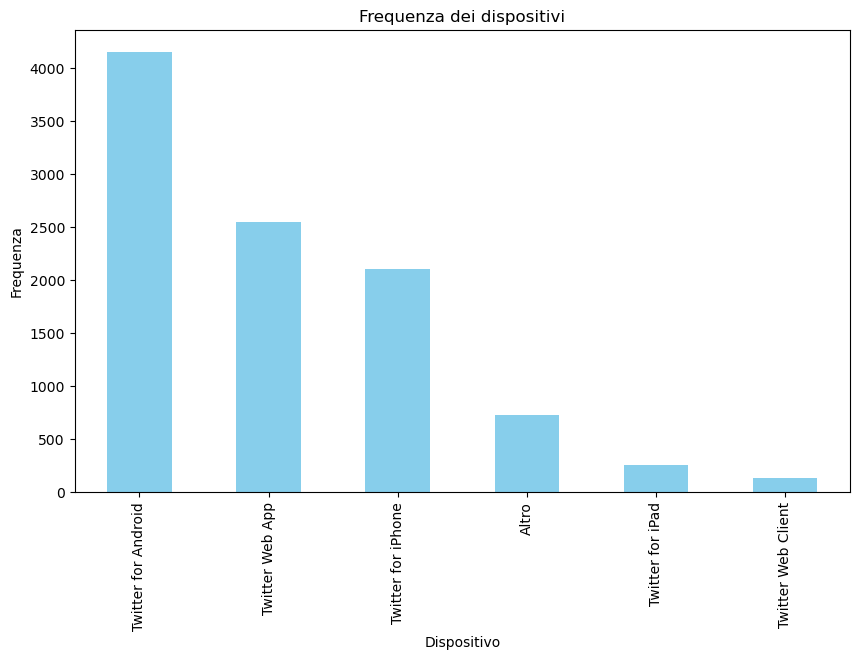

In [56]:
# Calcolare la frequenza di ogni valore unico nella colonna 'device'
device_counts = df['device'].value_counts()

# Creare un grafico a barre per visualizzare la frequenza
plt.figure(figsize=(10, 6))
device_counts.plot(kind='bar', color='skyblue')
plt.title('Frequenza dei dispositivi')
plt.xlabel('Dispositivo')
plt.ylabel('Frequenza')
plt.show()


#### qualche groupby di verifica tra metadati ed hate_speech

In [57]:
# Eseguire il groupby e sommare i valori della colonna 'favourite_count'
df.groupby('is_hate_speech')['favorite_count'].sum().reset_index() 

,is_hate_speech,favorite_count
0,0,357881.0
1,1,119290.0


In [58]:
df.groupby('is_hate_speech')['retweet_count'].sum().reset_index()

,is_hate_speech,retweet_count
0,0,92279.0
1,1,32551.0


 ## Feature enginering 
 
 **“Weighted_Engagement = (a * retweet_count) + (b * favorite_count) + (c * is_reply) + (d * is_retweet) + (e * is_quote)”**

In [59]:
# definisco i pesi a, b, c, e ed assegno arbitriamente pesi alle feature più rilevanti
a = 0.5
b = 0.3
c = 0.1
e = 0.1

# Creare la nuova feature Weighted_Engagement
df['Weighted_Engagement'] = (a * df['retweet_count']) + (b * df['favorite_count']) + (c * df['is_reply'])  + (e * df['is_quote'])


In [60]:
df.sort_values(by='Weighted_Engagement', ascending=False)

,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_quote,statuses_count,followers_count,friends_count,anonymized_description,month_tweet,month_user_creation,device,Weighted_Engagement
8510,Buon #25aprile a tutti!\nAnche ai politicanti ...,0,politics,2021-04-25,1541.0,23760.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,10693.0,2613003.0,820.0,“Mille” con Achille Lauro e Orietta Berti👇🏻💖,4,3,Twitter for iPhone,7898.5
4551,Che poi i politici che non festeggiano non han...,0,politics,2021-04-25,1699.0,10022.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,2329.0,276714.0,266.0,Felicemente insieme da 26 anni. Il nostro segr...,4,10,Twitter for iPhone,3856.1
1017,Dunque per convincere l'Europa a suddividere i...,0,politics,2019-09-23,1129.0,6043.0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",0.0,0.0,63796.0,152796.0,2683.0,Sono buono 🇪🇺 Please don't be rude at anybody ...,9,9,Twitter Web App,2377.4
554,#salvini è come allenatore che pensa che per n...,0,politics,2019-07-07,1163.0,5154.0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",0.0,0.0,25758.0,132172.0,13522.0,Rigore è quando arbitro fischia™ (non vero Bos...,7,6,Twitter Web App,2127.7
5617,"Tra i tagli automatici previsti dell’art.1, co...",0,politics,2019-01-06,1541.0,3913.0,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0.0,0.0,2020.0,243995.0,64.0,Direttore Osservatorio sui Conti Pubblici Ital...,1,12,Twitter Web Client,1944.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4353,Per ben 3 volte l’inviata a #PalazzoChigi del ...,0,politics,2021-04-24,0.0,0.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,7539.0,364.0,800.0,...cerco di capirlo...,4,4,Twitter for iPhone,0.0
4364,[URL]\n#salvinisciacallo mi fai schifo,1,politics,2021-04-24,0.0,0.0,"<a href=""http://twitter.com/download/android"" ...",0.0,0.0,19522.0,1765.0,2179.0,Bloccata su tutti i social dai camerati e i lo...,4,4,Twitter for Android,0.0
4370,L'Intelligenza artificiale sta trasformando le...,0,politics,2021-04-24,0.0,0.0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",0.0,0.0,6715.0,1840.0,2254.0,Eurocomunicazione è un think tank sull'Europa ...,4,5,Twitter Web App,0.0
8664,"Stimo #Draghi per quello che è stato, non lo e...",0,politics,2021-04-26,0.0,0.0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",0.0,0.0,4981.0,635.0,1016.0,"Sono cresciuto in un Paese che credevo magico,...",4,3,Twitter Web App,0.0


#### estrazione hashtag e plot Wordcloud

In [62]:
#isolare gli hashtag e completare le righe che non ne hanno

def extract_hashtags(tweet):
    hashtags = [word for word in tweet.split() if word.startswith('#')]
    return ' '.join(hashtags) if hashtags else 'No hashtags'


In [63]:
df['Hash_words_tweet'] = df['tweet'].apply(extract_hashtags)
df['Hash_words_ad'] = df['anonymized_description'].apply(extract_hashtags)

In [64]:
df.head()

,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_quote,statuses_count,followers_count,friends_count,anonymized_description,month_tweet,month_user_creation,device,Weighted_Engagement,Hash_words_tweet,Hash_words_ad
0,@unknown Con tutte le denunce che si sta becca...,1,politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,554.0,748.0,753.0,Avete presente quegli stereotipi sui siciliani...,8,4,Twitter for iPhone,1.9,No hashtags,No hashtags
1,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,35043.0,10838.0,4535.0,Prof di latino e Deputata PD.Ama lo sport la R...,11,10,Twitter for iPhone,211.4,#PRESCRIZIONE #m5s,No hashtags
2,Il #m5s ha votato contro le #unionicivili addu...,1,politics,2018-11-10,195.0,638.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,139750.0,7971.0,1866.0,"Medico, appassionato di Cinema d'Autore, Music...",11,9,Twitter for iPhone,288.9,#m5s #unionicivili #ddlPillon #NoPillon,No hashtags
3,La #Lega e il #m5s stanno dando a bere all'opi...,0,politics,2018-11-22,112.0,377.0,"<a href=""http://twitter.com/download/android"" ...",0.0,0.0,3356.0,8493.0,5303.0,no_description,11,11,Twitter for Android,169.1,"#Lega #m5s #proceduradiinfrazione #Pd, #22nove...",No hashtags
4,Che cosa cambia questa #legge? Caro @667517147...,0,politics,2018-12-02,45.0,143.0,"<a href=""http://twitter.com/#!/download/ipad"" ...",0.0,0.0,11234.0,10815.0,1810.0,Veneto! Assessore Regionale Sviluppo Economico...,12,1,Twitter for iPad,65.4,#legge? #decretoinsicurezza #lega #delinquenti...,No hashtags


In [65]:
df['Hash_words_tweet'].value_counts()

Hash_words_tweet
No hashtags                                                                                                                                                           2497
#SalviniPagliaccio                                                                                                                                                      76
#salvinisciacallo                                                                                                                                                       68
#Salviniportasfiga                                                                                                                                                      53
#governodeipeggiori                                                                                                                                                     49
                                                                                                                                

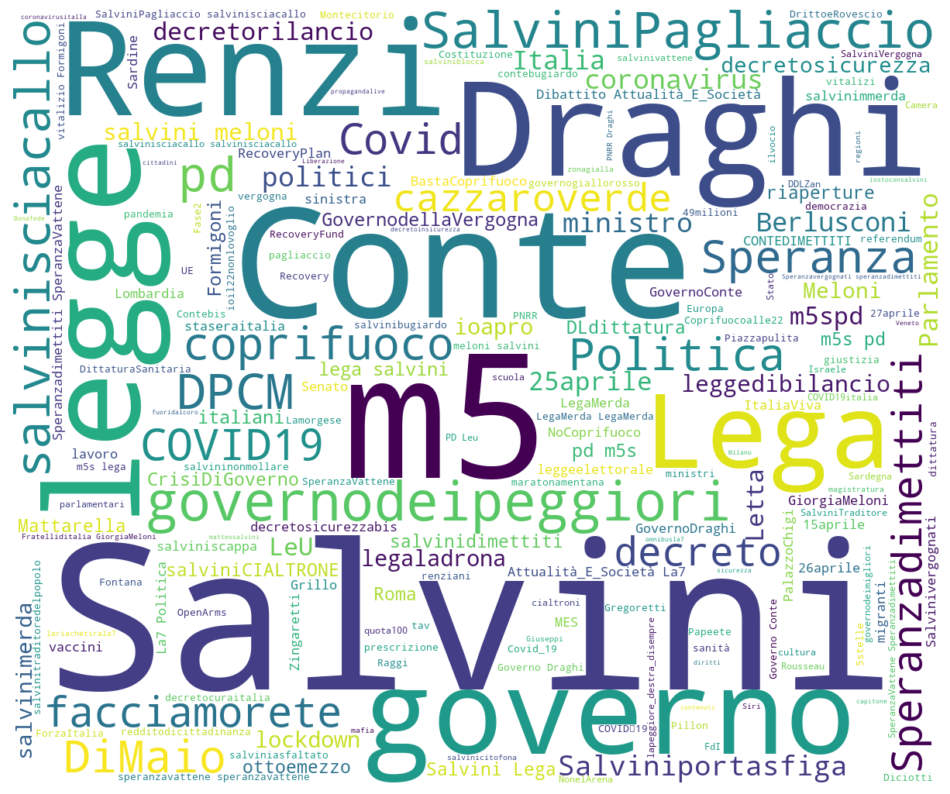

In [68]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filtra le righe con il valore 'No hashtags'
filtered_df = df[df['Hash_words_tweet'] != 'No hashtags']

# Unisci tutte le parole in una singola stringa
all_words = ' '.join(filtered_df['Hash_words_tweet'].astype(str))

# Crea l'oggetto WordCloud con dimensioni quadrate
wordcloud = WordCloud(width=1200, height=1000, random_state=21, background_color='white').generate(all_words)

# Plotta il WordCloud
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()




# Data Analysis and Cleaning

Funzione di pulizia del testo da caratteri indesiderati

In [364]:
import re

def clean_tweet(tweet):
    # Rimuovi URL
    tweet = re.sub(r"http[s]*\S+", "", tweet)
    
    # Rimuovi mentions (es. @utente)
    tweet = re.sub(r"@\S+", "", tweet)
    
    # Rimuovi hashtags (es. #hashtag)
    #tweet = re.sub(r"#\S+", "", tweet)

    # Rimuovi caratteri non alfanumerici eccetto spazi, apostrofi, punti, virgole, esclamazioni e punti di sospensione
    #tweet = re.sub(r"[^\w\s'.,!]", '', tweet)
    
    tweet = re.sub(r"[^a-zA-Z0-9\s'À-ÖØ-öø-ÿ]", '', tweet) #Questo dovrebbe permettere di conservare gli apostrofi e le parole con accenti.
    
    # Rimuovi numeri
    tweet = re.sub(r'\b\d+\b', '', tweet)
    
    # Rimuovi punteggiatura consecutiva
    tweet = re.sub("(.)\\1{2,}", r"\1", tweet)
    
    # Rimuovi spazi duplicati
    tweet = re.sub(r"\s{2,}", " ", tweet)
    
    return tweet.strip() #.lower()



df['clean_tweet'] = df['tweet'].apply(lambda x: clean_tweet(x))
df['clean_anonymized_description'] = df['anonymized_description'].apply(lambda x: clean_tweet(x))


#### aggiungo feature relative alla lunghezza dei tweet e count delle parole 


In [367]:
len(df['clean_tweet'][0])

119

In [368]:
df['tweet_len'] = df['clean_tweet'].astype(str).apply(len)
df['word_count'] = df['clean_tweet'].apply(lambda x: len(str(x).split()))

In [369]:
df.head(2)

,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_quote,statuses_count,...,month_tweet,month_user_creation,device,Weighted_Engagement,Hash_words_tweet,Hash_words_ad,clean_tweet,clean_anonymized_description,tweet_len,word_count
0,@unknown Con tutte le denunce che si sta becca...,1,politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,554.0,...,8,4,Twitter for iPhone,1.9,No hashtags,No hashtags,Con tutte le denunce che si sta beccando Salvi...,Avete presente quegli stereotipi sui siciliani...,119,20
1,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,35043.0,...,11,10,Twitter for iPhone,211.4,#PRESCRIZIONE #m5s,No hashtags,PRESCRIZIONE I tre magi hanno trovato laccordo...,Prof di latino e Deputata PDAma lo sport la Ro...,254,46


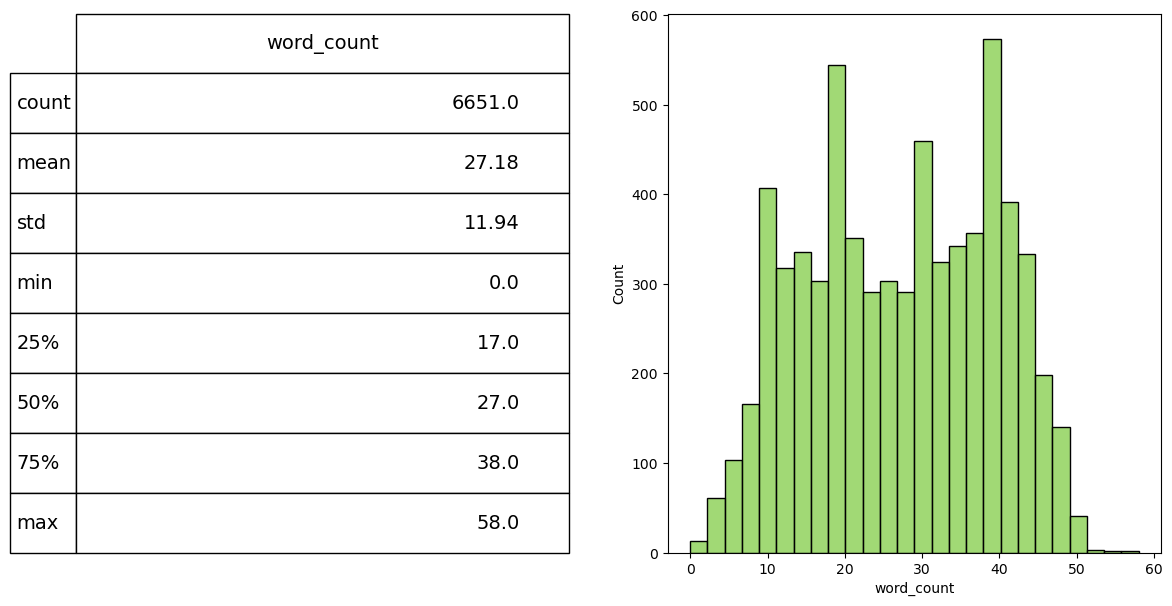

In [370]:
#classe 0 

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.histplot(df[df['is_hate_speech']==0]['word_count'], ax=ax1,color='#82CD47')
describe = df["word_count"][df["is_hate_speech"]==0].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
#fig.suptitle('Distribution of text length for positive sentiment headlines.', fontsize=16)

plt.show()

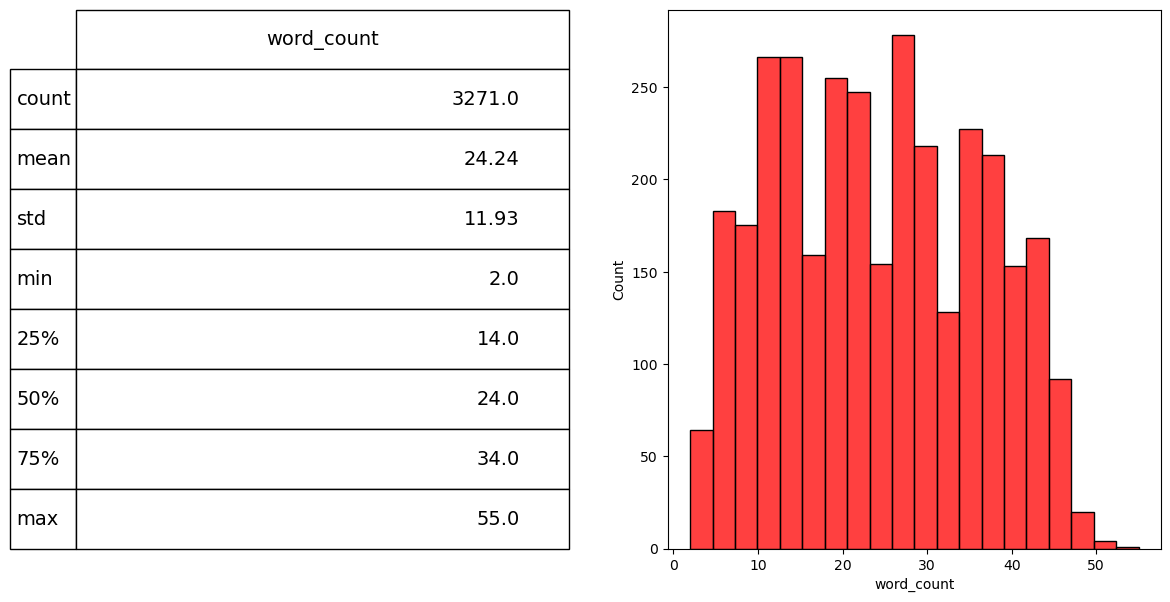

In [371]:
#classe 1

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.histplot(df[df['is_hate_speech']==1]['word_count'], ax=ax1,color='#FF0000')
describe = df["word_count"][df["is_hate_speech"]==1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
#fig.suptitle('Distribution of text length for negative sentiment headlines.', fontsize=16)

plt.show()

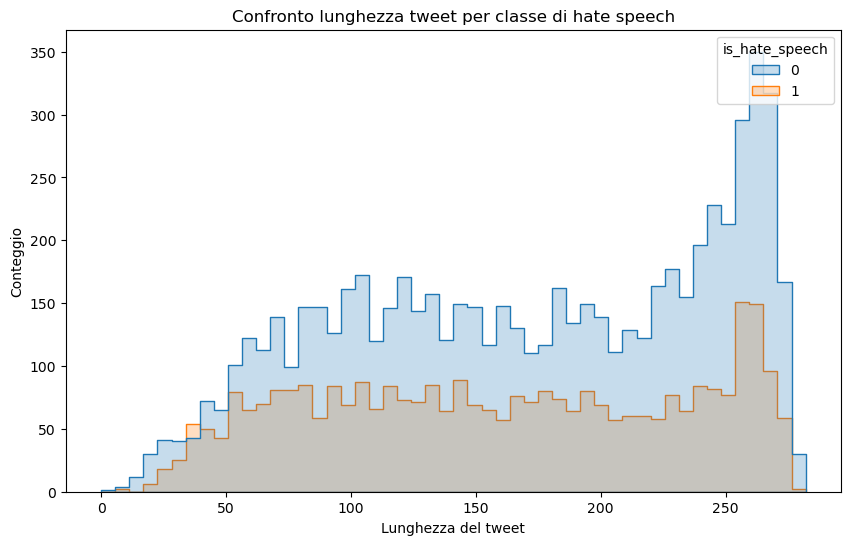

In [374]:
# Creazione dell'istogramma
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tweet_len', hue='is_hate_speech', bins=50,  element="step", common_norm=False)

# Aggiungi titoli e etichette
plt.title('Confronto lunghezza tweet per classe di hate speech')
plt.xlabel('Lunghezza del tweet')
plt.ylabel('Conteggio')

# Mostra l'istogramma
plt.show()

### Understanding e wordcloud


In [376]:
import nltk
nltk.download('stopwords')

# text cleaning
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HUAWEI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [377]:
#italian stopwords
additional  = ['rt','rts','retweet'] 
swords = set().union(stopwords.words('italian'),additional) #italian
#swords

In [378]:
#creo colonna per le wordlcloud
df['to_wordcloud'] = df['clean_tweet'].apply(lambda x: [i for i in x.split() if not i in swords])

In [379]:
print(df['tweet'][0])
print(df['clean_tweet'][0])
print(df['to_wordcloud'][0])

@unknown Con tutte le denunce che si sta beccando, Salvini rischia di far aumentare le statistiche dei reati commessi da italiani.
Con tutte le denunce che si sta beccando Salvini rischia di far aumentare le statistiche dei reati commessi da italiani
['Con', 'tutte', 'denunce', 'beccando', 'Salvini', 'rischia', 'far', 'aumentare', 'statistiche', 'reati', 'commessi', 'italiani']


In [380]:
#prova dividendo i domini
df_pol = df[df['dataset'] == 'politics']
df_rel = df[df['dataset'] == 'religious']

In [381]:
# wordcloud of the whole dataset
from wordcloud import WordCloud, STOPWORDS

bigstring     = df['to_wordcloud'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')
bigstring_pol = df_pol['to_wordcloud'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')
bigstring_rel = df_rel['to_wordcloud'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')

In [382]:
#levo anche le inglesi
#Since there are some very frequent words, which we already 
#know are the main topic of the dataset, we can remove them and re-do the wordcloud.

# wordcloud without some words INSERIRE QUELLE DA LEVARE
stopwords_1 = ["url", "cosa","perch",'solo', 'pi'] + list(STOPWORDS)
#stopwords_1

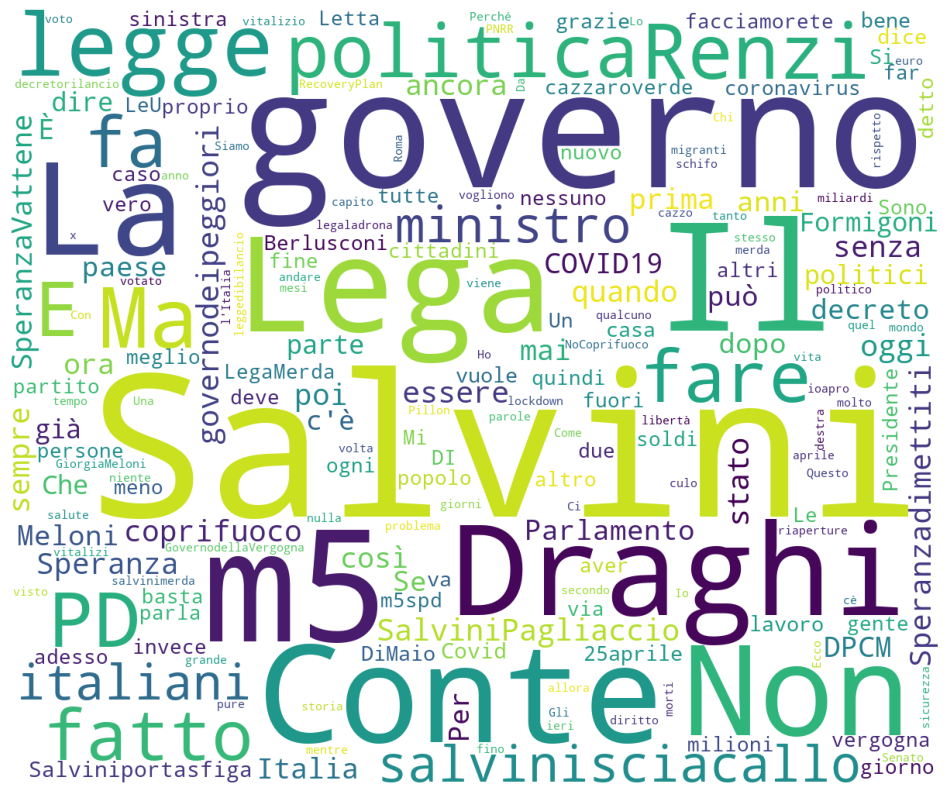

In [387]:
#DATASET POLITIC 
plt.figure(figsize=(12,12))
wordcloud1 = WordCloud(stopwords=stopwords_1,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(bigstring_pol)
plt.axis('off')
plt.imshow(wordcloud1)

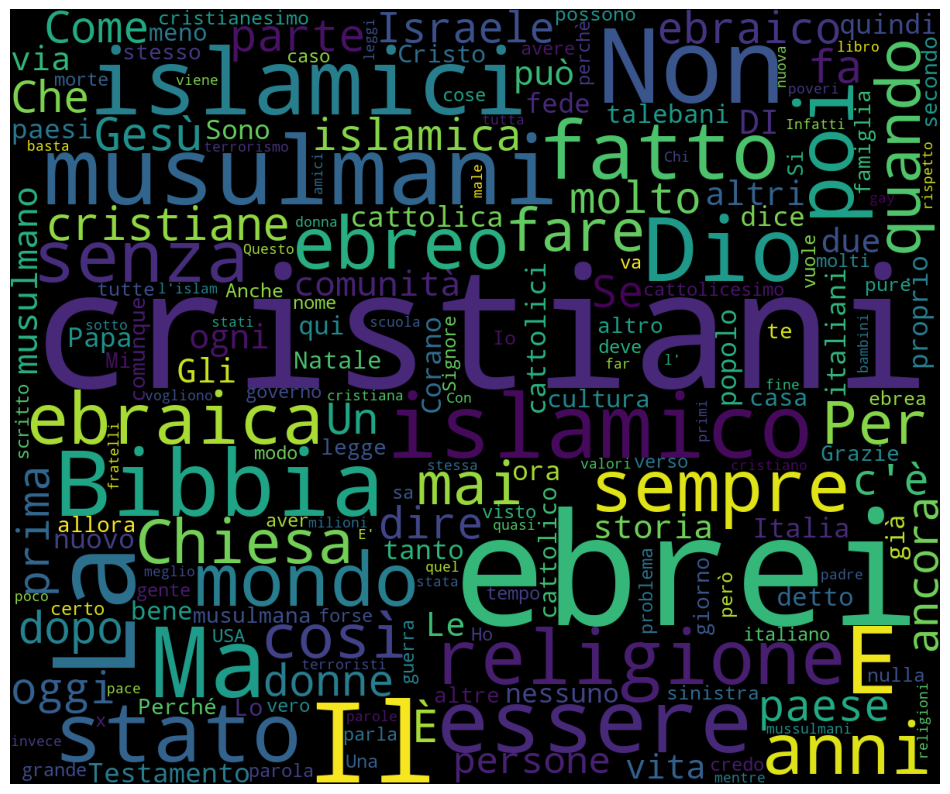

In [237]:
#DATASET RELIGIOUS
plt.figure(figsize=(12,12))
wordcloud2 = WordCloud(stopwords=stopwords_1,
                          background_color='black',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(bigstring_rel)
plt.axis('off')
plt.imshow(wordcloud2)

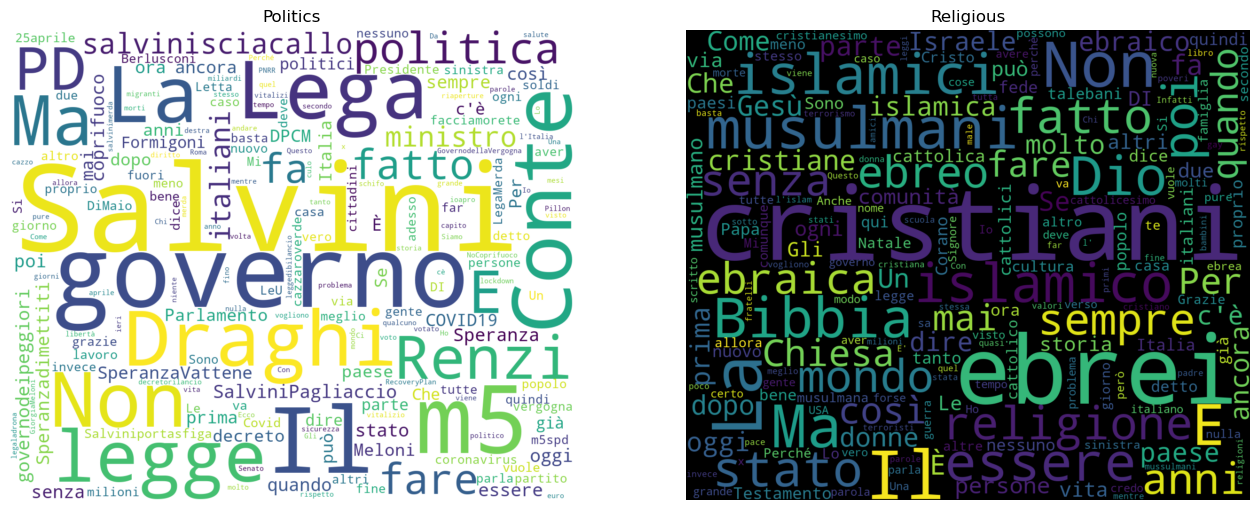

In [238]:
fig, axs = plt.subplots(1,2 , figsize=(16,8))

axs[0].imshow(wordcloud1, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Politics')

axs[1].imshow(wordcloud2, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Religious')

plt.show()

# Data preprocessing  
parto dalla colonna di testo pulita e procedo con:
- Tokenization
- Filtraggio delle Parole chiave
- Rimozione delle Stopwords, parole irrilevanti o corte
- Part-of-Speech (POS) Tagging:
- Lemmatization
- Stemming

In [240]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet # Pos tagging correspondence

from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS # Stop words
from gensim.models import Phrases # Compute bigrams.
from gensim.corpora import Dictionary # Utility to compute dictionary

# Ner visualization
import spacy
from spacy import displacy

In [241]:
df_preprocessed = df.copy()

In [242]:
df_preprocessed.head(2)

,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_quote,statuses_count,...,month_user_creation,device,Weighted_Engagement,Hash_words_tweet,Hash_words_ad,clean_tweet,clean_anonymized_description,tweet_len,word_count,to_wordcloud
0,@unknown Con tutte le denunce che si sta becca...,1,politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,554.0,...,4,Twitter for iPhone,1.9,No hashtags,No hashtags,Con tutte le denunce che si sta beccando Salvi...,Avete presente quegli stereotipi sui siciliani...,119,20,"[Con, tutte, denunce, beccando, Salvini, risch..."
1,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,35043.0,...,10,Twitter for iPhone,211.4,#PRESCRIZIONE #m5s,No hashtags,PRESCRIZIONE I tre magi hanno trovato laccordo...,Prof di latino e Deputata PDAma lo sport la Ro...,254,46,"[PRESCRIZIONE, I, tre, magi, trovato, laccordo..."


#### Tokeninzing the Text

In [243]:
import swifter
from nltk.tokenize import word_tokenize

df_preprocessed["tokenized_text"] = df_preprocessed.clean_tweet.swifter.apply(lambda x: word_tokenize(x))
df_preprocessed.head()

Pandas Apply:   0%|          | 0/9922 [00:00<?, ?it/s]

,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_quote,statuses_count,...,device,Weighted_Engagement,Hash_words_tweet,Hash_words_ad,clean_tweet,clean_anonymized_description,tweet_len,word_count,to_wordcloud,tokenized_text
0,@unknown Con tutte le denunce che si sta becca...,1,politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,554.0,...,Twitter for iPhone,1.9,No hashtags,No hashtags,Con tutte le denunce che si sta beccando Salvi...,Avete presente quegli stereotipi sui siciliani...,119,20,"[Con, tutte, denunce, beccando, Salvini, risch...","[Con, tutte, le, denunce, che, si, sta, beccan..."
1,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,35043.0,...,Twitter for iPhone,211.4,#PRESCRIZIONE #m5s,No hashtags,PRESCRIZIONE I tre magi hanno trovato laccordo...,Prof di latino e Deputata PDAma lo sport la Ro...,254,46,"[PRESCRIZIONE, I, tre, magi, trovato, laccordo...","[PRESCRIZIONE, I, tre, magi, hanno, trovato, l..."
2,Il #m5s ha votato contro le #unionicivili addu...,1,politics,2018-11-10,195.0,638.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,139750.0,...,Twitter for iPhone,288.9,#m5s #unionicivili #ddlPillon #NoPillon,No hashtags,Il m5s ha votato contro le unionicivili adduce...,Medico appassionato di Cinema d'Autore Musica ...,256,41,"[Il, m5s, votato, unionicivili, adducendo, scu...","[Il, m5s, ha, votato, contro, le, unionicivili..."
3,La #Lega e il #m5s stanno dando a bere all'opi...,0,politics,2018-11-22,112.0,377.0,"<a href=""http://twitter.com/download/android"" ...",0.0,0.0,3356.0,...,Twitter for Android,169.1,"#Lega #m5s #proceduradiinfrazione #Pd, #22nove...",No hashtags,La Lega e il m5s stanno dando a bere all'opini...,nodescription,247,39,"[La, Lega, m5s, dando, bere, all'opinione, pub...","[La, Lega, e, il, m5s, stanno, dando, a, bere,..."
4,Che cosa cambia questa #legge? Caro @667517147...,0,politics,2018-12-02,45.0,143.0,"<a href=""http://twitter.com/#!/download/ipad"" ...",0.0,0.0,11234.0,...,Twitter for iPad,65.4,#legge? #decretoinsicurezza #lega #delinquenti...,No hashtags,Che cosa cambia questa legge Caro con il decre...,Veneto Assessore Regionale Sviluppo Economico ...,192,31,"[Che, cosa, cambia, legge, Caro, decretoinsicu...","[Che, cosa, cambia, questa, legge, Caro, con, ..."


In [244]:
#verifico lunghezza prima e dopo stop words

i= 0
prima = len(df_preprocessed['tokenized_text'][i])

#### removing stopwords ITA ed EN +  Filtering out short words + parole inutili

In [245]:
import nltk
from nltk.corpus import stopwords

# Scarica le stop words italiane e inglesi
nltk.download('stopwords')
stop_words_italian = set(stopwords.words('italian'))
stop_words_english = set(stopwords.words('english'))

# Lista di parole personalizzate da rimuovere
custom_stop_words = ['url', 'volere', 'dire', 'fare', 'solo', 'cosa', 'essere', 'fatto', 'fa', 
                     'poi', 'sempre', 'quando','oggi', 'cè', 'così', 'può','già', 'dice', 'ogni', 
                     'va', 'vuole', 'quindi', 'detto', 'deve', 'invece', 'far','tutte', ]

# Funzione per rimuovere le stop words, le parole di una sola lettera e le parole personalizzate dalla lista di token
def remove_stopwords_and_short_words(token_list):
    return [word for word in token_list if len(word) > 1 and 
            word.lower() not in stop_words_italian and 
            word.lower() not in stop_words_english and 
            word.lower() not in custom_stop_words]

# Applica la nuova funzione alla colonna 'tokenized_tweet' del DataFrame
df_preprocessed['tokenized_text'] = df_preprocessed['tokenized_text'].apply(remove_stopwords_and_short_words)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HUAWEI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [246]:
i= 8
print(len(df_preprocessed['to_wordcloud'][i]))
print(len(df_preprocessed['tokenized_text'][i]))

print((df_preprocessed['to_wordcloud'][i]))
print((df_preprocessed['tokenized_text'][i]))

17
15
['Ma', 'carfagna', 'crosetto', 'sinistra', 'bersani', 'fassina', 'forse', 'riformista', 'renzi', 'torto', 'no', 'Fanculo', 'presunzione', "de'", 'stò', 'cazzo', 'senzadime']
['carfagna', 'crosetto', 'sinistra', 'bersani', 'fassina', 'forse', 'riformista', 'renzi', 'torto', 'Fanculo', 'presunzione', 'de', 'stò', 'cazzo', 'senzadime']


verifica delle parole piu frequenti da poter togliere manualmente

In [247]:
import pandas as pd
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

N = 100

# Concatena tutte le liste di token in un'unica lista
all_tokens = [token for sublist in df_preprocessed['tokenized_text'] for token in sublist]

# Calcola le frequenze delle parole
freq_dist = FreqDist(all_tokens)

# Trova le N parole più frequenti
top_words = freq_dist.most_common(N)

# Stampa le parole più frequenti
print(top_words)


[('Salvini', 831), ('governo', 650), ('cristiani', 558), ('salvini', 555), ('m5s', 529), ('legge', 526), ('Draghi', 454), ('ebrei', 454), ('Conte', 398), ('Lega', 372), ('stato', 336), ('senza', 326), ('italiani', 302), ('anni', 301), ('ancora', 295), ('salvinisciacallo', 294), ('mai', 286), ('SalviniPagliaccio', 277), ('prima', 275), ('Governo', 275), ('Renzi', 267), ('governodeipeggiori', 264), ('parte', 262), ('M5S', 259), ('politica', 254), ('Italia', 247), ('coprifuoco', 247), ('ministro', 231), ('dopo', 229), ('Speranza', 215), ('conte', 213), ('lega', 206), ('ora', 197), ('bene', 195), ('persone', 194), ('casa', 190), ('SperanzaVattene', 186), ('paese', 185), ('mondo', 180), ('altri', 177), ('PD', 176), ('politici', 173), ('musulmani', 171), ('due', 169), ('decreto', 166), ('via', 165), ('sinistra', 163), ('proprio', 162), ('vita', 160), ('giorno', 157), ('COVID19', 156), ('gente', 153), ('islamici', 153), ('lavoro', 151), ('molto', 148), ('Speranzadimettiti', 148), ('altro', 14

#### pos tagging per italiano con Spacy

The Part Of Speech tag. Valid options are `"n"` for nouns, `"v"` for verbs, `"a"` for adjectives, `"r"` for adverbs and `"s"` for satellite adjectives.

In [248]:
import spacy

# Carico il modello linguistico di spaCy
nlp = spacy.load("it_core_news_sm") 

In [249]:
# Applica il POS tagging
df_preprocessed['pos_tags'] = df_preprocessed['tokenized_text'].apply(lambda x: [(token.text, token.pos_) for token in nlp(' '.join(x))])

df_preprocessed[['tokenized_text', 'pos_tags']]


,tokenized_text,pos_tags
0,"[denunce, beccando, Salvini, rischia, aumentar...","[(denunce, NOUN), (beccando, VERB), (Salvini, ..."
1,"[PRESCRIZIONE, tre, magi, trovato, laccordo, p...","[(PRESCRIZIONE, VERB), (tre, NUM), (magi, NOUN..."
2,"[m5s, votato, unionicivili, adducendo, scuse, ...","[(m5s, NOUN), (votato, VERB), (unionicivili, N..."
3,"[Lega, m5s, dando, bere, all'opinione, pubblic...","[(Lega, VERB), (m5s, PROPN), (dando, VERB), (b..."
4,"[cambia, legge, Caro, decretoinsicurezza, lega...","[(cambia, VERB), (legge, NOUN), (Caro, ADJ), (..."
...,...,...
9995,"[Esatto, brava, dico, piu, nazisti, cercarono,...","[(Esatto, NOUN), (brava, ADJ), (dico, AUX), (p..."
9996,"[Togliere, parola, vaccinati, mettere, ebrei, ...","[(Togliere, VERB), (parola, NOUN), (vaccinati,..."
9997,"[sai, musulmani, riconoscono, Cristo, profeta,...","[(sai, VERB), (musulmani, NOUN), (riconoscono,..."
9998,"[Berlino, Memoriale, ebrei, assassinati, dEuro...","[(Berlino, PROPN), (Memoriale, PROPN), (ebrei,..."


In [250]:
df_preprocessed['pos_tags'][3]

[('Lega', 'VERB'),
 ('m5s', 'PROPN'),
 ('dando', 'VERB'),
 ('bere', 'VERB'),
 ("all'", 'ADP'),
 ('opinione', 'NOUN'),
 ('pubblica', 'ADJ'),
 ('proceduradiinfrazione', 'NOUN'),
 ('colpa', 'NOUN'),
 ('Pd', 'PROPN'),
 ('Renzi', 'PROPN'),
 ('Gentiloni', 'PROPN'),
 ('inquietante', 'ADJ'),
 ('italiani', 'ADJ'),
 ('credendo', 'VERB'),
 ('davvero', 'ADV'),
 ('Onestà', 'PROPN'),
 ('intellettuale', 'ADJ'),
 ('pari', 'ADJ'),
 ('22novembre', 'NOUN'),
 ('manovradelpopolo', 'ADV')]

In [251]:
list_of_tags = df_preprocessed.pos_tags.swifter.apply(lambda x: [el[1] for el in x if len(el) == 2]).tolist()
set_of_tags = set()

for ls in list_of_tags:
    for tag in ls:
        set_of_tags.add(tag)

Pandas Apply:   0%|          | 0/9922 [00:00<?, ?it/s]

In [252]:
#used to interpret the postag to wordnet lexicon
def get_wordnet_pos(treebank_tag):
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [253]:
pos_mapper = {k : get_wordnet_pos(k) for k in set_of_tags}
list(pos_mapper.items())[:5]

[('VERB', 'v'), ('NUM', 'n'), ('NOUN', 'n'), ('ADJ', None), ('PROPN', None)]

#### lemmatization

In [257]:
# Funzione per lemmatizzare un testo tokenizzato
def lemmatize_tokens(tokens):
    # Unisci i token in una stringa e crea un oggetto Doc di spaCy
    text = ' '.join(tokens)
    doc = nlp(text)
    
    # Estrai lemmi dai token
    lemmatized_tokens = [token.lemma_ for token in doc]
    
    return lemmatized_tokens

# Applica la funzione al dataframe
df_preprocessed['lemmatized_text'] = df_preprocessed['tokenized_text'].apply(lemmatize_tokens)

In [258]:
df_preprocessed[['tokenized_text', 'lemmatized_text']]

,tokenized_text,lemmatized_text
0,"[denunce, beccando, Salvini, rischia, aumentar...","[denuncia, beccare, Salvini, rischiare, aument..."
1,"[PRESCRIZIONE, tre, magi, trovato, laccordo, p...","[PRESCRIZIONE, tre, mago, trovare, laccordo, p..."
2,"[m5s, votato, unionicivili, adducendo, scuse, ...","[m5s, votare, unionicivile, adducere, scusa, v..."
3,"[Lega, m5s, dando, bere, all'opinione, pubblic...","[lega, m5s, dare, bere, a il, opinione, pubbli..."
4,"[cambia, legge, Caro, decretoinsicurezza, lega...","[cambiare, legge, Caro, decretoinsicurezza, le..."
...,...,...
9995,"[Esatto, brava, dico, piu, nazisti, cercarono,...","[esatto, bravo, dico, piu, nazista, cercare, t..."
9996,"[Togliere, parola, vaccinati, mettere, ebrei, ...","[Togliere, parola, vaccinare, mettere, ebreo, ..."
9997,"[sai, musulmani, riconoscono, Cristo, profeta,...","[sai, musulmano, riconoscere, Cristo, profetar..."
9998,"[Berlino, Memoriale, ebrei, assassinati, dEuro...","[Berlino, Memoriale, ebreo, assassinare, dEuro..."


In [259]:
#test per verifica del risultato
i= 5
print(len(df_preprocessed['tokenized_text'][i]))
print(len(df_preprocessed['lemmatized_text'][i]))

print((df_preprocessed['tokenized_text'][i]))
print((df_preprocessed['lemmatized_text'][i]))

22
22
['Spero', 'rientrino', 'insegnanti', 'Sud', 'Sud', 'Dopo', 'anni', 'Milano', 'vorrei', 'ricongiungermi', 'famiglia', 'neppure', 'giusto', 'tramite', 'assegnazioni', 'provvisorie', 'alunni', 'cambino', 'insegnanti', 'anni', 'legge107', 'tempopieno']
['sperare', 'rientrino', 'insegnante', 'Sud', 'Sud', 'Dopo', 'anno', 'Milano', 'volere', 'ricongiungere mi', 'famiglia', 'neppure', 'giusto', 'tramite', 'assegnazione', 'provvisorio', 'alunno', 'cambare', 'insegnante', 'anno', 'legge107', 'tempopieno']


#### stemming dei token

In [260]:
from nltk.stem.snowball import SnowballStemmer

# Inizializza lo stemmer per l'italiano
stemmer = SnowballStemmer("italian")

# Funzione per eseguire lo stemming su una lista di token
def stem_tokens_italian(token_list):
    return [stemmer.stem(token) for token in token_list]

# Applica la funzione alla colonna 'tokenized_tweet' del DataFrame
df_preprocessed['stemmed_text'] = df_preprocessed['tokenized_text'].apply(stem_tokens_italian)


In [261]:
df_preprocessed.head(3)

,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_quote,statuses_count,...,Hash_words_ad,clean_tweet,clean_anonymized_description,tweet_len,word_count,to_wordcloud,tokenized_text,pos_tags,lemmatized_text,stemmed_text
0,@unknown Con tutte le denunce che si sta becca...,1,politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,554.0,...,No hashtags,Con tutte le denunce che si sta beccando Salvi...,Avete presente quegli stereotipi sui siciliani...,119,20,"[Con, tutte, denunce, beccando, Salvini, risch...","[denunce, beccando, Salvini, rischia, aumentar...","[(denunce, NOUN), (beccando, VERB), (Salvini, ...","[denuncia, beccare, Salvini, rischiare, aument...","[denunc, becc, salvin, risc, aument, statist, ..."
1,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,35043.0,...,No hashtags,PRESCRIZIONE I tre magi hanno trovato laccordo...,Prof di latino e Deputata PDAma lo sport la Ro...,254,46,"[PRESCRIZIONE, I, tre, magi, trovato, laccordo...","[PRESCRIZIONE, tre, magi, trovato, laccordo, p...","[(PRESCRIZIONE, VERB), (tre, NUM), (magi, NOUN...","[PRESCRIZIONE, tre, mago, trovare, laccordo, p...","[prescrizion, tre, mag, trov, laccord, prim, l..."
2,Il #m5s ha votato contro le #unionicivili addu...,1,politics,2018-11-10,195.0,638.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,139750.0,...,No hashtags,Il m5s ha votato contro le unionicivili adduce...,Medico appassionato di Cinema d'Autore Musica ...,256,41,"[Il, m5s, votato, unionicivili, adducendo, scu...","[m5s, votato, unionicivili, adducendo, scuse, ...","[(m5s, NOUN), (votato, VERB), (unionicivili, N...","[m5s, votare, unionicivile, adducere, scusa, v...","[m5s, vot, unionicivil, adduc, scus, vergogn, ..."


In [262]:
df_preprocessed.shape

(9922, 28)

## Integrazione  bad words come nuova feature
https://www.freewebheaders.com/italian-swear-words-list-and-curse-words-free-download/

In [264]:
df_preprocessed

,tweet,is_hate_speech,dataset,created_at,retweet_count,favorite_count,source,is_reply,is_quote,statuses_count,...,Hash_words_ad,clean_tweet,clean_anonymized_description,tweet_len,word_count,to_wordcloud,tokenized_text,pos_tags,lemmatized_text,stemmed_text
0,@unknown Con tutte le denunce che si sta becca...,1,politics,2018-08-11,0.0,6.0,"<a href=""http://twitter.com/download/iphone"" r...",1.0,0.0,554.0,...,No hashtags,Con tutte le denunce che si sta beccando Salvi...,Avete presente quegli stereotipi sui siciliani...,119,20,"[Con, tutte, denunce, beccando, Salvini, risch...","[denunce, beccando, Salvini, rischia, aumentar...","[(denunce, NOUN), (beccando, VERB), (Salvini, ...","[denuncia, beccare, Salvini, rischiare, aument...","[denunc, becc, salvin, risc, aument, statist, ..."
1,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,politics,2018-11-08,154.0,448.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,35043.0,...,No hashtags,PRESCRIZIONE I tre magi hanno trovato laccordo...,Prof di latino e Deputata PDAma lo sport la Ro...,254,46,"[PRESCRIZIONE, I, tre, magi, trovato, laccordo...","[PRESCRIZIONE, tre, magi, trovato, laccordo, p...","[(PRESCRIZIONE, VERB), (tre, NUM), (magi, NOUN...","[PRESCRIZIONE, tre, mago, trovare, laccordo, p...","[prescrizion, tre, mag, trov, laccord, prim, l..."
2,Il #m5s ha votato contro le #unionicivili addu...,1,politics,2018-11-10,195.0,638.0,"<a href=""http://twitter.com/download/iphone"" r...",0.0,0.0,139750.0,...,No hashtags,Il m5s ha votato contro le unionicivili adduce...,Medico appassionato di Cinema d'Autore Musica ...,256,41,"[Il, m5s, votato, unionicivili, adducendo, scu...","[m5s, votato, unionicivili, adducendo, scuse, ...","[(m5s, NOUN), (votato, VERB), (unionicivili, N...","[m5s, votare, unionicivile, adducere, scusa, v...","[m5s, vot, unionicivil, adduc, scus, vergogn, ..."
3,La #Lega e il #m5s stanno dando a bere all'opi...,0,politics,2018-11-22,112.0,377.0,"<a href=""http://twitter.com/download/android"" ...",0.0,0.0,3356.0,...,No hashtags,La Lega e il m5s stanno dando a bere all'opini...,nodescription,247,39,"[La, Lega, m5s, dando, bere, all'opinione, pub...","[Lega, m5s, dando, bere, all'opinione, pubblic...","[(Lega, VERB), (m5s, PROPN), (dando, VERB), (b...","[lega, m5s, dare, bere, a il, opinione, pubbli...","[leg, m5s, dand, ber, all'opinion, pubblic, pr..."
4,Che cosa cambia questa #legge? Caro @667517147...,0,politics,2018-12-02,45.0,143.0,"<a href=""http://twitter.com/#!/download/ipad"" ...",0.0,0.0,11234.0,...,No hashtags,Che cosa cambia questa legge Caro con il decre...,Veneto Assessore Regionale Sviluppo Economico ...,192,31,"[Che, cosa, cambia, legge, Caro, decretoinsicu...","[cambia, legge, Caro, decretoinsicurezza, lega...","[(cambia, VERB), (legge, NOUN), (Caro, ADJ), (...","[cambiare, legge, Caro, decretoinsicurezza, le...","[camb, legg, car, decretoinsicurezz, leg, dovr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"@306266219847013 Esatto brava , ti dico di piu...",0,religious,2021-08-31,0.0,0.0,"<a href=""https://mobile.twitter.com"" rel=""nofo...",1.0,0.0,10922.0,...,No hashtags,Esatto brava ti dico di piu i nazisti nel cerc...,Il Covid e le guerre sono il braccio armato de...,216,38,"[Esatto, brava, dico, piu, nazisti, cercarono,...","[Esatto, brava, dico, piu, nazisti, cercarono,...","[(Esatto, NOUN), (brava, ADJ), (dico, AUX), (p...","[esatto, bravo, dico, piu, nazista, cercare, t...","[esatt, brav, dic, piu, nazist, cerc, trasfer,..."
9996,@527727106662135 Togliere la parola non vaccin...,0,religious,2021-08-31,0.0,0.0,"<a href=""http://twitter.com/download/android"" ...",1.0,0.0,721.0,...,No hashtags,Togliere la parola non vaccinati e mettere ebr...,Galileo Copernico Giordano Bruno furono consid...,57,10,"[Togliere, parola, vaccinati, mettere, ebrei, ...","[Togliere, parola, vaccinati, mettere, ebrei, ...","[(Togliere, VERB), (parola, NOUN), (vaccinati,...","[Togliere, parola, vaccinare,

In [265]:
#lista completa

bad_words = "a fanabla, a pecorina, abcdiet, accidenti, accidenti , affanculo, alla cazzo di cane, alla pecorina, allupato, amico del cazzo, ammucchiata, anabootcampdiet, anale, andare a puttane, arrapato, arrusa, arruso, assatanato, avere la faccia come il culo, avere un culo così grande, bacha ma culo, bafangu chooch, bagasce, bagascia, bagascione, bagassa, bagnarsi, baldracca, baldraccacce, baldraccaccia, baldracche, baldraccona, baldraccone, balle, bariledimerda, bastardacce, bastardacci, bastardaccia, bastardaccio, bastardamadonna, bastarde, bastardi, bastardo, bastardona, bastardone, bastardoni, battere, battona, battone, bbwpit, belino, biga, bimbominkia, bocchinara, bocchinare, bocchinari, bocchinaro, bocchini, bocchino, bofilo, boiata, bordello, brinca, brutto cornuto, brutto figlio di puttana bastardo, brutto stronzo, bucaiolo, budellodidio, budiùlo, buona donna, busone, bustadipiscio, cacaminchia, cacare, cacasotto, cacata, cacca, caciocappella, cadavere, cagacazzo, cagaminchia, cagare, cagasotto, cagata, cagna, cammello, canacciodidio, canagliadidio, caned'allah, caned'eva, canedidio, cappella, carciofo, carità, carogna, caronya, casci, cavolate, cavolo, cazzacci, cazzaccio, cazzaro, cazzata, cazzate, cazzetti, cazzetto, cazzi, cazzimma, cazzissimo, cazzo, cazzo di merda, cazzo in culo, cazzo madre di dio, cazzo si, cazzona, cazzone, cazzoni, cazzuta, cazzute, cazzuti, cazzutissimo, cazzuto, ce l’hai piccolo, ce un cibirut, cesso, che cavolo, che cavolo., che cazzo, che cazzo fai?, che cazzo ne so, che culo, che due coglioni, che due palle, che palle, che te pozzino ammazza, checca, checche, chi cazzo sei tu?, chiappa, chiavare, chiavata, chiavate, chiavatona, chiavatone, chissenefrega, chissenefrega?, ci sei cascato come una pirla, ciolla, ciolle, ciornia, ciospo, ciucciamelo, ciucciami il cazzo, ciucciapalle, cogliona, coglionaggine, coglionare, coglionata, coglionate, coglionatore, coglionatrice, coglionatura, coglionature, coglionazzi, coglionazzo, coglioncelli, coglioncello, coglioncini, coglioncino, coglione, coglioneria, coglionerie, coglioni, col cavolo, coprofago, coprofilo, cornuti, cornuto, cornutoilpapa, cozza, cozzo, credoana, cretinetti, cretino, cristod'undio, cristodecapitato, cristoincroce, culattina, culattone, culattoni, culi, culo, culona, culone, curnut, dare un calcio nel culo a qualcuno, deficiente, di merda, dietaabc, dietaana, dietaanabootcamp, dietabootcamp, dietadell'abc, dio bastardo, dio boia, dio cane, dio cangurello, dio dannato, dio fa, dio Fottuto, dio infame, dio lupo, dio maiale, dio merda, dio merdoso, dio mona, dio poj, dio povero, dio santo, dio schifoso, dio serpente, dio sorcio, dio stronzo, dio verme, dio zozzo, diobastardo, diobestia, diobestiazza, dioboia, diocan, diocane, diocannaiolo, diocapra, diocoglione, diocomunista, diocrasto, diocristo, dioculattone, diofarabutto, diofascista, diofinocchio, dioflagellato, dioimpestato, dioimpiccato, dioladro, diolebbroso, diolobotomizzato, diolurido, diomaiale, diomaledetto, diomerda, diominchione, dionegro, dioporco, diopoveraccio, diopovero, diorotto, diorottoinculo, diorutto, diosbudellato, dioschifoso, dioseppellito, dioserpente, diostracane, diostramerda, diostronzo, diosventrato, dioverme, ditalini, ditalino, dito al, dove cazzo vai?, duro, e che cazzo, essere un culo, fa cagare, fa schifo, faccia a culo, faccia di culo, faccia di merda, facciadaculo, facciadimerda, fanculo, fare una sega, fare unaŠ, fatti i cazzi tuoi, fatti una pugnetta, fava, femminuccia, fica, ficata, ficate, fiche, fichetta, fichette, fichetti, fichetto, ficona, ficone, figa, figata, figate, fighe, fighetta, fighette, fighetti, fighetto, figliadicane, figliadimignotta, figliadiputtana, figliaditroia, figlidicani, figlidimignotta, figlidiputtana, figliditroia, figliedicani, figliedimignotta, figliediputtana, figlieditroia, figlio di buona donna, figlio di mignotta, figlio di puttana, figlio di troia, figlio un cane, figliodicane, figliodimignotta, figliodiputtana, figlioditroia, figona, figone, figoni, figura di merda, finocchi, finocchio, fongoul, formaggio, fottere, fottersi, fottiti, fottuta, fottute, fottuti, fottutissima, fottutissime, fottutissimi, fottutissimo, fottuto, fracicone, frega un cazzo, fregna, frocetto, froci, frociara, frociaro, frociarola, frociarolo, frocio, frocione, frocioni, frocissimo, froscio, fucker, fumato il cervello, fuori come un balcone, garibaldi, gesùcristaccio, gesùesorcizzato, gesùhandicappato, gesùimpasticcato, gesùmalandato, gesùradioattivo, gesùsieropositivo, gesùstordito, gesùzozzo, gnocca, gnocche, goldone, gran’ disgraziato, grilletto, guanto, guardone, heyyyyy, i coglioni, incazzare, incazzarsi, incazzata, incazzate, incazzati, incazzatissima, incazzatissime, incazzatissimi, incazzatissimo, incazzato, incazzato nero, incoglionirsi, inculare, inculata, inculate, infrociato, ingoio, intro culo di mammata, ir budello di tu ma’, l'arte bolognese, latrin, leccacazzi, leccaculi, leccaculo, leccafica, leccafiga, leccafighe, leccami il culo, leccami la figa, leccapalle, lecchino, levati dai coglioni, li mortacci tua, lofare, loffa, loffare, lui è proprio un bischero, lui è un coglione, lumaca, ma’ va te ne a fanculo, Madonna, Madonna avvelenata, Madonna bastarda, Madonna bocchinara, Madonna impalata, Madonna infiammata, Madonna maiala, Madonna mignotta, Madonna puttana, madonna santa, Madonna schifosa, Madonna strega, Madonna svergognata, Madonna troia, Madonna zoccola, madonnaassassinata, madonnacane, madonnaimpestata, madonnaisterica, madonnalurida, madonnamaiala, madonnamongoloide, madonnanegra, madonnaputtana, madonnaschiava, madonnastregaccia, madonnasudicia, madonnasuicida, madonnasurgelata, madonnatroia, madonnaviolentata, mafankulo, maiala, manache, mangia la minchia, mangia merda, mangia merde e morte, manico, mannaggia, mannaggia tua, mannaggiacristo, mannaggiadio, mannaggiailbattesimo, mannaggiailclero, mannaggiaisanti, mannaggial'arcangelo, mannaggialabibbia, mannaggialadiocesi, mannaggialamadonna, mannaggialaputtana, mannaggiapadrepio, mannaggiasangiuseppe, merda, merdacce, merdaccia, merdamalcagata, merdata, merdate, merde, merdina, merdine, merdolina, merdoline, merdona, merdone, merdosa, merdose, merdosi, merdoso, mezza sega, mezzasega, mezzeseghe, mi stai facendo incazzare, micio, mignotta, mignotte, minchia, minchiadura, minchiaduro, minchiata, minchiate, minchie, minchione, minchioni, miserabili pezzo di merda, mona, mone, mongoloide, monta, montare, mortacci tua, mussa, nave scuola, negra, negraccia, negraccio, negro, negrona, negrone, nel culo, nerchia, nessuno mi unfungulo, non hai capito una sega, non me ne importa, non mi rompere i coglioni, nudo, oddio, padulo, palle, palloso, patacca, patonza, patonze, pecorina, perché cazzo non mi rispondi?, pesce, pezzo di merda, picio, pigliacazzi, pigliainculo, pincare, pinnolone, pipa, pipì, pippone, pirla, pisciare, pisciasotto, pisciata, pisciatina, pisciato, pisciatona, piscio, pisciona, piscione, piscioni, pisello, pistola, pistolotto, pomiciare, pompa, pompinara, pompinare, pompinari, pompinaro, pompini, pompino, porca, porca madonna, porca miseria, porca paletta, porca puttana, porca troia, porca vacca, porcamadonna, porcaputtana, porco, porco cane, porco dio, porco due, porco giuda, porco Iddio, porco zio, porcodidio, porcodio, porcoilclero, porcoilsignore, posso leccare il tua figa?, potta, prendere per il culo, prete, pro-ana, pro-anoressia, pro-bulimia, pro-ed, pro-ednos, pro-mia, proana, proanoressia, probulimia, proed, proednos, promia, pugnetta, pugnette, puppa, puppamela, puppamelo, puppami, puppare, puppe, puttana, puttana la Madonna, puttanacce, puttanaccia, puttanaeva, puttanaio, puttanamadonna, puttanata, puttanate, puttane, puttanella, puttanelle, puttaniere, puttanieri, puttano, puttanona, puttanone, quaglia, quando cazzo torni?, raspone, rasponi, recchione, regina, ricchione, ricchioni, rincoglionire, rincoglionito, rizzacazzi, rizzarsi, rompere i miei coglioni, rompere il culo a qualcuno, rompiballe, rompicazzi, rompicazzo, rompicoglioni, rompipalle, rotta in culo, rottinculo, rotto nel culo, ruffiano, santo cazzo madre di cristo, sbattere, sbattersi, sbocchinare, sbocchinato, sbocchiniamolo, sbora, sborra, sborrare, sborrata, sborrate, sborrato, sborratona, sborro, sborrone, sbrodolata, sburra, sburrare, sburro, scassacazzo, scassacoglioni, scassaminchia, scazzare, scazzata, scazzate, scazzati, scazzato, schifoso, scopare, scopata, scopate, scoregge, scoreggia, scorreggiare, scungio, secchione, sega, segaiolo, segars, seghe, segone, sei diventato pazza?, sei diventato pazzo?, sei duro come il muro, sei impazzita?, sei impazzito?, sei pazza?, sei pazzo?, sei scemo, sei stupido, sei un cretino, sei un deficiente, sei un idiota, sei un rompicoglioni, sei una sfigata, sei una testa di cazzo, sei uno stronzo, sembri un peni, sfacim e merde, sfiga, sfigati, sfigato, signorebastardo, slinguare, slinguata, smandrappata, smerdare, soccia, socmel, sorca, spagnola, spompinare, spompinata, spompinato, spompiniamolo, sputtanare, sta puttana, sti cazza, sticchio, stronza, stronzata, stronzate, stronzetta, stronzette, stronzetti, stronzetto, stronzi, stronzina, stronzine, stronzini, stronzino, stronzino/a, stronzo, stronzo/a, stronzoli, stronzolo, stronzomalcagato, stronzona, stronzone, stronzoni, strunzo, suca!, succhiacazzi, succhiamelo, succhiami, succhiaminchia, succhiapalle, succhione, sveltina, sverginare, tarzanelli, tarzanello, tenere qualcuno per le palle, terrone, testa di cazzo, testa di cazzo., testa di minchia, tetta, tette, tettina, tettine, tettona, tettone, thinspiration, thinspo, ti ammazzo, ti corro in culo, ti sei bevuto, tirare, topa, troia, troiacce, troiaccia, troiamadonna, troie, troietta, troiette, troio, troiona, troioncella, troioncelle, troione, trombare, trombata, trombatona, tu ma’ piscia in piedi, tu piezza di merda, tua mamma bocchinara, uccello, un pompino, va’ a cacare, va’ a farti fottere, vacca, vaccamadonna, vada a bordo, vaffanculo, vaffanculo a chi t'è morto, vaffonculo, vai a cacare, vai a cagare, vai a farti fottere, vai a farti fottere, puttana, vai a quel paese, Vai a vendere il culo, vai all’inferno, vangare, vattela a pigliare in culo, venire, zinne, zio cantante, zoccola, zoccole, zuia"

In [266]:
#definisco funzione per pulizia della lista

def elimina_spazi_dopo_virgole(input_string):
    # Dividi la stringa in una lista di sottostringhe separate dalle virgole
    lista_sottostringhe = input_string.split(',')

    # Rimuovi gli spazi iniziali da ogni sottostringa
    lista_sottostringhe_senza_spazi = [sottostringa.lstrip() for sottostringa in lista_sottostringhe]

    # Unisci le sottostringhe senza spazi utilizzando una virgola come separatore
    risultato = ','.join(lista_sottostringhe_senza_spazi)

    return risultato

In [267]:
bad_words

['a fanabla',
 'a pecorina',
 'abcdiet',
 'accidenti',
 'accidenti ',
 'affanculo',
 'alla cazzo di cane',
 'alla pecorina',
 'allupato',
 'amico del cazzo',
 'ammucchiata',
 'anabootcampdiet',
 'anale',
 'andare a puttane',
 'arrapato',
 'arrusa',
 'arruso',
 'assatanato',
 'avere la faccia come il culo',
 'avere un culo così grande',
 'bacha ma culo',
 'bafangu chooch',
 'bagasce',
 'bagascia',
 'bagascione',
 'bagassa',
 'bagnarsi',
 'baldracca',
 'baldraccacce',
 'baldraccaccia',
 'baldracche',
 'baldraccona',
 'baldraccone',
 'balle',
 'bariledimerda',
 'bastardacce',
 'bastardacci',
 'bastardaccia',
 'bastardaccio',
 'bastardamadonna',
 'bastarde',
 'bastardi',
 'bastardo',
 'bastardona',
 'bastardone',
 'bastardoni',
 'battere',
 'battona',
 'battone',
 'bbwpit',
 'belino',
 'biga',
 'bimbominkia',
 'bocchinara',
 'bocchinare',
 'bocchinari',
 'bocchinaro',
 'bocchini',
 'bocchino',
 'bofilo',
 'boiata',
 'bordello',
 'brinca',
 'brutto cornuto',
 'brutto figlio di puttana basta

In [292]:
# # Function to count bad words in a tokenized OR LEMMATIZED tweet 
def count_bad_words(tokenized_tweet):
    return sum(1 for word in tokenized_tweet if word.lower() in bad_words)


# Apply the count_bad_words function to create a new column 'bad_words_count'
df_preprocessed['bad_words_count'] = df_preprocessed['lemmatized_text'].apply(count_bad_words)


In [293]:
df_preprocessed.head(2)

,tweet,is_hate_speech,dataset,retweet_count,favorite_count,is_reply,is_quote,statuses_count,followers_count,friends_count,...,clean_tweet,clean_anonymized_description,tweet_len,word_count,tokenized_text,pos_tags,lemmatized_text,stemmed_text,swear_word_bin,bad_words_count
0,@unknown Con tutte le denunce che si sta becca...,1,0,0.0,6.0,1.0,0.0,554.0,748.0,753.0,...,Con tutte le denunce che si sta beccando Salvi...,Avete presente quegli stereotipi sui siciliani...,119,20,"[denunce, beccando, Salvini, rischia, aumentar...","[(denunce, NOUN), (beccando, VERB), (Salvini, ...","[denuncia, beccare, Salvini, rischiare, aument...","[denunc, becc, salvin, risc, aument, statist, ...",0,0
1,#PRESCRIZIONE : I (t)re magi hanno trovato l’a...,0,0,154.0,448.0,0.0,0.0,35043.0,10838.0,4535.0,...,PRESCRIZIONE I tre magi hanno trovato laccordo...,Prof di latino e Deputata PDAma lo sport la Ro...,254,46,"[PRESCRIZIONE, tre, magi, trovato, laccordo, p...","[(PRESCRIZIONE, VERB), (tre, NUM), (magi, NOUN...","[PRESCRIZIONE, tre, mago, trovare, laccordo, p...","[prescrizion, tre, mag, trov, laccord, prim, l...",0,0


In [291]:
df_preprocessed['bad_words_count'].value_counts()

bad_words_count
0    8973
1     838
2      95
3      13
4       1
6       1
5       1
Name: count, dtype: int64

In [272]:
# Definisci una funzione per creare la nuova colonna binaria
def create_binary_column(count):
    return 1 if count > 0 else 0

# Applica la funzione alla colonna 'bad_words_count' per creare la nuova colonna binaria
df_preprocessed['swear_word_bin'] = df_preprocessed['bad_words_count'].apply(create_binary_column)

# Visualizza il DataFrame risultante
df_preprocessed[['bad_words_count', 'swear_word_bin']]


,bad_words_count,swear_word_bin
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
...,...,...
9995,0,0
9996,0,0
9997,0,0
9998,0,0


In [273]:
df_preprocessed['swear_word_bin'].value_counts()

swear_word_bin
0    9032
1     890
Name: count, dtype: int64

# creazione csv finale
rimuovo le features che non mi serviranno 

In [274]:
df_preprocessed.columns

Index(['tweet', 'is_hate_speech', 'dataset', 'created_at', 'retweet_count',
       'favorite_count', 'source', 'is_reply', 'is_quote', 'statuses_count',
       'followers_count', 'friends_count', 'anonymized_description',
       'month_tweet', 'month_user_creation', 'device', 'Weighted_Engagement',
       'Hash_words_tweet', 'Hash_words_ad', 'clean_tweet',
       'clean_anonymized_description', 'tweet_len', 'word_count',
       'to_wordcloud', 'tokenized_text', 'pos_tags', 'lemmatized_text',
       'stemmed_text', 'bad_words_count', 'swear_word_bin'],
      dtype='object')

In [275]:
from sklearn.preprocessing import LabelEncoder

# Lista di colonne da codificare
columns_to_encode = ['device',"dataset"]

# Creare un oggetto LabelEncoder per ogni colonna
label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    #df_preprocessed[column + '_encoded'] = label_encoders[column].fit_transform(df_preprocessed[column])
    df_preprocessed[column] = label_encoders[column].fit_transform(df_preprocessed[column])
    


In [276]:
to_drop = ['source', 'month_tweet', 'month_user_creation', 'to_wordcloud', 'created_at', 'bad_words_count']

In [278]:
# Esegui il drop delle colonne
df_preprocessed = df_preprocessed.drop(to_drop, axis=1)

In [296]:
df_preprocessed.shape

(9922, 25)

In [279]:
# Specifica del percorso del file CSV
percorso_file_csv = 'df_preprocessed.csv'

# Salvataggio del DataFrame nel file CSV
df_preprocessed.to_csv(percorso_file_csv, index=False)